In [1]:
import torch
import torch.nn as nn
import timm
import numpy as np
import scipy.io
import time

from einops import repeat, rearrange
from einops.layers.torch import Rearrange

from timm.models.layers import trunc_normal_
from timm.models.vision_transformer import Block

def random_indexes(size : int):
    forward_indexes = np.arange(size)
    np.random.shuffle(forward_indexes)
    backward_indexes = np.argsort(forward_indexes)
    return forward_indexes, backward_indexes

def take_indexes(sequences, indexes):
    return torch.gather(sequences, 0, repeat(indexes, 't b -> t b c', c=sequences.shape[-1]))

def mat2tensor64(V_mat):
    print("Converting mat to tensor...")
    start_time = time.time()
    new_matrices = []

    # Process each (16, 16) matrix
    for matrix_index in range(V_mat.shape[0]):
        # Initialize the new (64, 64) matrix
        V0_mat_64x64 = np.zeros((64, 64), dtype=np.float16)
        
        # Populate the new matrix
        for i in range(16):
            for j in range(16):
                value = np.float16(V_mat[matrix_index, i, j])  # Convert the value to float16
                V0_mat_64x64[i*4:(i+1)*4, j*4:(j+1)*4] = np.full((4, 4), value, dtype=np.float16)
        
        # Add the new matrix to the list
        new_matrices.append(V0_mat_64x64)

    # Convert the list to a numpy array
    V_new = np.array(new_matrices)

    # print(f"New matrices dtype: {V_new.dtype}")  # Should be float16
    # print(f"New matrices shape: {V_new.shape}")  # Should be (11520, 64, 64)

    # Save the new matrices to a .npy file
    # np.save('Data/V/V_EIM0_64x64.npy', V_new)
    V_tensor = torch.tensor(V_new).unsqueeze(1).float()
    # print(f"New tensor shape: {V_tensor.shape}")  # Should be (11520, 1, 64, 64)
    # Move the tensor to the GPU if available
    if torch.cuda.is_available():
        V_tensor = V_tensor.to('cuda')
        
    end_time = time.time() - start_time
    print(f"Tensor loaded. time is {end_time}")
    
    return V_tensor

class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches : torch.Tensor):
        T, B, C = patches.shape
        remain_T = int(T * (1 - self.ratio))

        indexes = [random_indexes(T) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=-1), dtype=torch.long).to(patches.device)

        patches = take_indexes(patches, forward_indexes)
        patches = patches[:remain_T]

        return patches, forward_indexes, backward_indexes
    
class MAE_Encoder(torch.nn.Module):
    def __init__(self,
                 image_size=64,
                 patch_size=4,
                 emb_dim=256,
                 num_layer=12,
                 num_head=4,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.cls_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2, 1, emb_dim))
        self.shuffle = PatchShuffle(mask_ratio)

        self.patchify = torch.nn.Conv2d(1, emb_dim, patch_size, patch_size)

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.layer_norm = torch.nn.LayerNorm(emb_dim)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.cls_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding

        patches, forward_indexes, backward_indexes = self.shuffle(patches)

        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')

        return features, backward_indexes

class MAE_Decoder(torch.nn.Module):
    def __init__(self,
                 image_size=64,
                 patch_size=4,
                 emb_dim=256,
                 num_layer=2,
                 num_head=4,
                 ) -> None:
        super().__init__()

        self.mask_token = torch.nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embedding = torch.nn.Parameter(torch.zeros((image_size // patch_size) ** 2 + 1, 1, emb_dim))

        self.transformer = torch.nn.Sequential(*[Block(emb_dim, num_head) for _ in range(num_layer)])

        self.head = torch.nn.Linear(emb_dim, 3 * patch_size ** 2) # ! 3 channels, 模型文件中改为1
        self.patch2img = Rearrange('(h w) b (c p1 p2) -> b c (h p1) (w p2)', p1=patch_size, p2=patch_size, h=image_size//patch_size)

        self.init_weight()

    def init_weight(self):
        trunc_normal_(self.mask_token, std=.02)
        trunc_normal_(self.pos_embedding, std=.02)

    def forward(self, features, backward_indexes):
        T = features.shape[0]
        backward_indexes = torch.cat([torch.zeros(1, backward_indexes.shape[1]).to(backward_indexes), backward_indexes + 1], dim=0)
        features = torch.cat([features, self.mask_token.expand(backward_indexes.shape[0] - features.shape[0], features.shape[1], -1)], dim=0)
        features = take_indexes(features, backward_indexes)
        features = features + self.pos_embedding

        features = rearrange(features, 't b c -> b t c')
        features = self.transformer(features)
        features = rearrange(features, 'b t c -> t b c')
        features = features[1:] # remove global feature

        patches = self.head(features)
        mask = torch.zeros_like(patches)
        mask[T-1:] = 1
        mask = take_indexes(mask, backward_indexes[1:] - 1)
        img = self.patch2img(patches)
        mask = self.patch2img(mask)

        return img, mask

'''
for img_size 64:
all params set as
ViT_large / 4
'''
class MAE_ViT(torch.nn.Module):
    def __init__(self,
                 image_size=64,
                 patch_size=4,
                 emb_dim=256,
                 encoder_layer=12,
                 encoder_head=4,
                 decoder_layer=2,
                 decoder_head=4,
                 mask_ratio=0.75,
                 ) -> None:
        super().__init__()

        self.encoder = MAE_Encoder(image_size, patch_size, emb_dim, encoder_layer, encoder_head, mask_ratio)
        self.decoder = MAE_Decoder(image_size, patch_size, emb_dim, decoder_layer, decoder_head)

    def forward(self, img):
        features, backward_indexes = self.encoder(img)
        predicted_img, mask = self.decoder(features,  backward_indexes)
        return predicted_img, mask

class ViT_Classifier(torch.nn.Module):
    def __init__(self, encoder : MAE_Encoder, num_classes=10) -> None:
        super().__init__()
        self.cls_token = encoder.cls_token
        self.pos_embedding = encoder.pos_embedding
        self.patchify = encoder.patchify
        self.transformer = encoder.transformer
        self.layer_norm = encoder.layer_norm
        self.head = torch.nn.Linear(self.pos_embedding.shape[-1], num_classes)

    def forward(self, img):
        patches = self.patchify(img)
        patches = rearrange(patches, 'b c h w -> (h w) b c')
        patches = patches + self.pos_embedding
        patches = torch.cat([self.cls_token.expand(-1, patches.shape[1], -1), patches], dim=0)
        patches = rearrange(patches, 't b c -> b t c')
        features = self.layer_norm(self.transformer(patches))
        features = rearrange(features, 'b t c -> t b c')
        logits = self.head(features[0])
        return logits


/home/ronald/anaconda3/envs/new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 加载数据+数据划分
V_EIM_tensor = torch.tensor(np.load('Data/V/V_EIM5_64.npy'))
# x_train = V_EIM_tensor # 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# shuffle = PatchShuffle(0.75)
# a = torch.rand(16, 2, 10)
# b, forward_indexes, backward_indexes = shuffle(a)

test_img = V_EIM_tensor[-500:].to(device)
encoder = MAE_Encoder(mask_ratio=0.75).to(device)
#encoder = MAE_Encoder_nomask(mask_ratio=0).to(device)
decoder = MAE_Decoder().to(device)

In [4]:

# encoder.load_state_dict(torch.load("Model/V_pretrain/0716/MAE_smae_encoder_mr0.75_eb256.pth"),strict=False)
encoder.load_state_dict(torch.load("Model/V_pretrain/MAE_img64_encoder_mr0.75_eb256_data492500.pth"), strict=False)
decoder.load_state_dict(torch.load("Model/V_pretrain/MAE_img64_decoder_mr0.75_eb256_data492500.pth"),strict=False)
features, backward_indexes = encoder(test_img) # b_i mask position info
predicted_test_img, mask = decoder(features, backward_indexes)

predicted_m = predicted_test_img * mask + test_img * (1 - mask)
# img = torch.cat([test_img * (1 - mask), predicted_test_img, test_img], dim=0)
# img = rearrange(img, '(v h1 w1) c h w -> c (h1 h) (w1 v w)', w1=2, v=3)

In [5]:
print(test_img.shape)
print(predicted_test_img.shape)
print(predicted_m.shape)

torch.Size([500, 1, 64, 64])
torch.Size([500, 3, 64, 64])
torch.Size([500, 3, 64, 64])


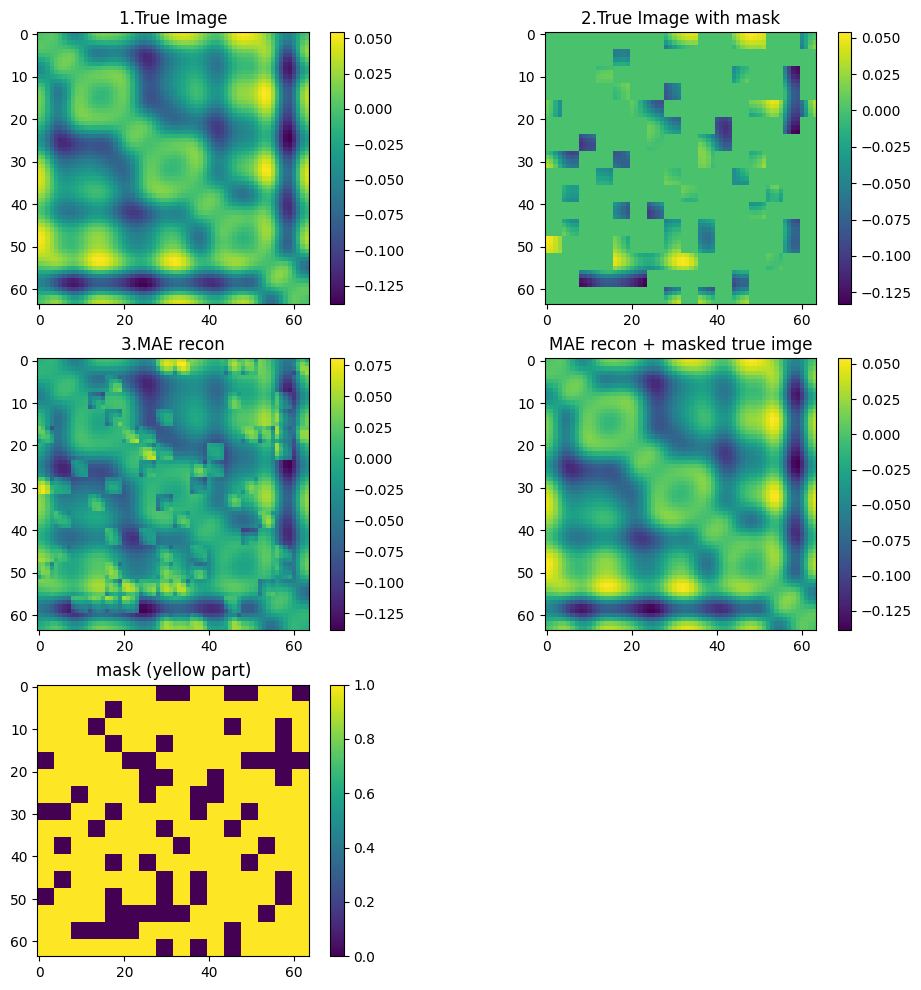

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
# 随机选择测试数据并预测
idx = 33
# channel = 1
img_real = test_img
img_real_mask = test_img*(1-mask)
# img_d = img_real[idx][channel]
# img_mask_d = img_real_mask[idx][channel]
# predicted_img_d = predicted_test_img[idx][channel]
# predicted_m_d = predicted_m[idx][channel]
img_d = img_real[idx][0]
#save img_d as txt
# np.savetxt(f'img_d_{idx}.txt', img_d.cpu().numpy())
img_mask_d = img_real_mask[idx][0]
predicted_img_d = predicted_test_img[idx][0]
predicted_m_d = predicted_m[idx][0]


# 绘制真实图像和重构图像
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.imshow(img_d.detach().cpu().numpy())
plt.title('1.True Image')
plt.colorbar()


plt.subplot(3, 2, 2)
plt.imshow(img_mask_d.detach().cpu().numpy())
plt.title('2.True Image with mask')
plt.colorbar()

plt.subplot(3, 2, 3)
plt.imshow(predicted_img_d.detach().cpu().numpy())
plt.title('3.MAE recon')
plt.colorbar()

plt.subplot(3, 2, 4)
plt.imshow(predicted_m_d.detach().cpu().numpy())
plt.title('MAE recon + masked true imge')
plt.colorbar()

mask_d = mask[idx][0]
plt.subplot(3, 2, 5)
plt.imshow(mask_d.detach().cpu().numpy())
plt.title('mask (yellow part)')
plt.colorbar()